In [407]:
import pandas as pd
import openpyxl #for reading or saving to Excel
import xlsxwriter
import sys

import state_country_dicts as scd
import requests
from bs4 import BeautifulSoup as bs
# import regular expressions
import re 
import time

In [408]:
def clean_up (number_str):
    '''This is a clean up routine so that only numeric characters remain'''
    number_str = number_str.replace(',', '').replace('null','0').rstrip(']').lstrip("'")
    return int(number_str)

In [409]:
pwd

'/Users/edwardterrell/Desktop/covid_machinations'

In [410]:
# The start dates for U.S.states and for countries are different so must be accounted for
# st_start = pd.Timestamp('2020/3/13')
c_start = pd.Timestamp('2020/2/16')

# set end time to yesterday

#day == pd.Timestamp.today().strftime('%Y-%m-%d')
end = pd.Timestamp.today() - pd.Timedelta(days=1)
print(f'end changed to yesterday: {end}')
#else:
#   end = pd.Timestamp.today()
#    print(f'end changed to {end}')
    
# set the index to the appropriate date range for states and countries
#st_index = pd.date_range(st_start, end)
c_index = pd.date_range(c_start, end)
#len(st_index)
len(c_index)

# list comprehension to extract just the state initials from the dict
#st_list = list(state_dict.values())

# create an empty pandas df with column headers from state_dict
#state = pd.DataFrame(columns = st_list,index=st_index)
#state.sort_index(ascending = False).head()
#state.shape

end changed to yesterday: 2022-01-10 14:52:45.263058


695

In [411]:

# creates a custom country dict
c_string = input('Enter country codes seperated by a space:') or 'fr it es'
clist = scd.custom_list (c_string)

country_dict = {key: value for key, value in scd.all_countries.items() if value in clist}
print(country_dict)

print()

Enter country codes seperated by a space: 


{'spain': 'ES', 'france': 'FR', 'italy': 'IT'}



In [412]:
c_list = list(country_dict.values())
c_list

['ES', 'FR', 'IT']

In [413]:
# create an empty pandas df with column headers from country_dict, using the starting dates for the country as index
country = pd.DataFrame(columns = c_list,index=c_index)
country.sort_index(ascending = False).head()

,ES,FR,IT
2022-01-10,NaN,NaN,NaN
2022-01-09,NaN,NaN,NaN
2022-01-08,NaN,NaN,NaN
2022-01-07,NaN,NaN,NaN
2022-01-06,NaN,NaN,NaN


In [414]:
base_url='https://www.worldometers.info/coronavirus/country/'
# Here the keys are the country names and the values are the 2-letter abbreviation
for key, value in country_dict.items():
    url = base_url+key
    print(url)

    # scrape web page for country info and assign to soup
    response = requests.get(url)
    #response.status_code
    page = response.text
    #print(response.text[:400])
    soup = bs(page)
    
    # Find block of text/data near 'graph-cases-daily' 
    re_graph = re.compile('graph-cases')
    dat = soup.find(text=re_graph)
   
    try:
        data = soup.find(text=re_graph).parent
    except:
        print(f'Unable to find {url}')
        print()
        break

    # Regex to pull out data chunk out of the larger soup like data
    myregex = re.compile (r'data:.*\]')
    mo = myregex.search(str(data))

    #mo.group() is a string so easy to get rid of the first entry
    country_previous_cases = mo.group().split(',')[1:]
    #print(country_previous_cases)
    previous_cases = ["0" if i == 'null' else i for i in country_previous_cases]
    
    len(previous_cases)

    # merge countries into the existing df and apply the function clean_up to convert strings to ints
    country[value] = previous_cases
    country[value] = country[value].fillna(0).apply(clean_up)
    
    time.sleep(2)
country.clip(lower=0,inplace=True) #large negative number removed for better graphic clarity
country.sort_index(ascending = False).head()

https://www.worldometers.info/coronavirus/country/spain
https://www.worldometers.info/coronavirus/country/france
https://www.worldometers.info/coronavirus/country/italy


,ES,FR,IT
2022-01-10,97464,93896,101749
2022-01-09,97465,296097,155986
2022-01-08,97465,303669,197951
2022-01-07,115900,328214,108515
2022-01-06,126540,261481,219897


### Scrape Section

In [339]:
url='https://www.worldometers.info/coronavirus/'
# scrape web page for table
response = requests.get(url)
print(response.status_code)
page = response.text
soup = bs(page)

200


In [266]:
country_href = [item for item in soup.find('tbody').find_all(class_='mt_a')]
country_names = [item.text for item in soup.find('tbody').find_all(class_='mt_a')]
print (f'country_names is length {len(country_names)}')
print (f'country_href (country_list2) is length {len(country_href)}')

country_names is length 221
country_href (country_list2) is length 221


In [267]:
country_href[-5:]

[<a class="mt_a" href="country/samoa/">Samoa</a>,
 <a class="mt_a" href="country/saint-helena/">Saint Helena</a>,
 <a class="mt_a" href="country/micronesia/">Micronesia</a>,
 <a class="mt_a" href="country/tonga/">Tonga</a>,
 <a class="mt_a" href="country/china/">China</a>]

In [268]:
country_list2 = []
for item in country_href:
    country_list2.append(item['href'][8:-1])

In [269]:
country_list2[-5:]

['samoa', 'saint-helena', 'micronesia', 'tonga', 'china']

In [270]:
country_names[-5:]

['Samoa', 'Saint Helena', 'Micronesia', 'Tonga', 'China']

In [271]:
df = pd.DataFrame({'country':country_list2,'country_names':country_names})
df.set_index('country', inplace=True)
df.shape

(221, 1)

In [62]:
df.tail()

,country_names
country,
samoa,Samoa
saint-helena,Saint Helena
micronesia,Micronesia
tonga,Tonga
china,China


### pop section

In [368]:
print (soup.find('tbody').find_all('a')[0].text)
print([item for item in soup.find('tbody').find_all('a')][1].text)

USA
333,961,250


In [369]:
world_list = [item for item in soup.find('tbody').find_all('a') if 'pop' in item['href']]
print(len(world_list))
world_list[70:75]

218


[<a href="/world-population/uruguay-population/">3,492,082</a>,
 <a href="/world-population/norway-population/">5,485,849</a>,
 <a href="/world-population/venezuela-population/">28,313,087</a>,
 <a href="/world-population/ethiopia-population/">119,297,417</a>,
 <a href="/world-population/state-of-palestine-population/">5,281,919</a>]

In [325]:
for item in world_list[:3]:
    print(item['href'][18:-12])
    print(item.text)

us
333,961,250
india
1,400,680,035
brazil
214,862,375


In [326]:
country_list3 = []
pop_list = []
for item in world_list:
    country_list3.append(item['href'][18:-12])
    pop_item = clean_up (item.text)
    pop_list.append(pop_item)

In [327]:
df2=pd.DataFrame({'country':country_list3, 'population':pop_list})
df2.set_index('country', inplace=True)
df2.shape

(218, 1)

In [328]:
df2.head()

,population
country,
us,333961250
india,1400680035
brazil,214862375
uk,68429595
france,65493709


### Merge section

In [340]:
world_pop_df  = df.merge(df2,how='outer',left_index=True,right_index=True)
world_pop_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222 entries, afghanistan to zimbabwe
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_names  221 non-null    object 
 1   population     218 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.2+ KB


In [341]:
world_pop_df[world_pop_df['country_names'].isnull()].index.tolist()

['palau']

In [342]:
world_pop_df[world_pop_df['population'].isnull()].index.tolist()

['china', 'israel', 'new-zealand', 'qatar']

In [343]:
#name repair
world_pop_df.loc['palau','country_names'] = 'Palau'

#population repair
world_pop_df.loc['china','population'] = 1444000000
world_pop_df.loc['israel','population'] = 9200000
world_pop_df.loc['new-zealand','population'] = 5000000
world_pop_df.loc['qatar','population'] = 2900000
world_pop_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222 entries, afghanistan to zimbabwe
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_names  222 non-null    object 
 1   population     222 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.3+ KB


In [357]:
new_w_list = world_pop_df.index.to_list()

In [359]:
w_list = list(scd.all_countries.keys())

In [ ]:
test=[]
for country in new_w_list:
    if country in w_list:
        pass
    else:
        print(country)
        test.append(country)

In [365]:
len(test)

38

### new population data

In [415]:
df = pd.read_csv('population_by_country_2020.csv',usecols=(0,1))
df.columns = ['country','population']


df.to_csv('world_pop.csv',index=False)

world_pop = pd.read_csv('world_pop.csv').iloc[:,0:2].set_index('country')
world_pop['pop_millions'] = world_pop.population/1000000
world_pop.head()

,population,pop_millions
country,,
China,1440297825,1440.297825
India,1382345085,1382.345085
United States,331341050,331.341050
Indonesia,274021604,274.021604
Pakistan,221612785,221.612785


In [416]:
clist

['FR', 'IT', 'ES']

In [417]:
iso3166r = scd.reverse_dict(scd.iso3166)

In [418]:
import state_country_dicts as scd
#list(scd.all_countries.items())

country_dict = {key: value for key, value in scd.iso3166r.items() if value in clist}
#print(country_dict)
w_cols = list(country_dict.keys())
w_cols

['Spain', 'France', 'Italy']

In [419]:
# Extract just the populations for the states of interest
wpop_series = world_pop.loc[w_cols].pop_millions
wpop_series

country
Spain     46.757980
France    65.298930
Italy     60.446035
Name: pop_millions, dtype: float64

In [421]:
wpop_series.index

Index(['Spain', 'France', 'Italy'], dtype='object', name='country')

In [423]:
wpop_series.rename(index=iso3166r, inplace=True)

In [424]:
wpop_series.index

Index(['ES', 'FR', 'IT'], dtype='object', name='country')

In [425]:
world_cases_by_million = country/wpop_series
world_cases_by_million.tail()

,ES,FR,IT
2022-01-06,2706.276020,4004.368831,3637.906109
2022-01-07,2478.721279,5026.330447,1795.237686
2022-01-08,2084.457027,4650.443736,3274.838457
2022-01-09,2084.457027,4534.484715,2580.582829
2022-01-10,2084.435641,1437.940867,1683.303131


In [427]:
import matplotlib.pyplot as plt

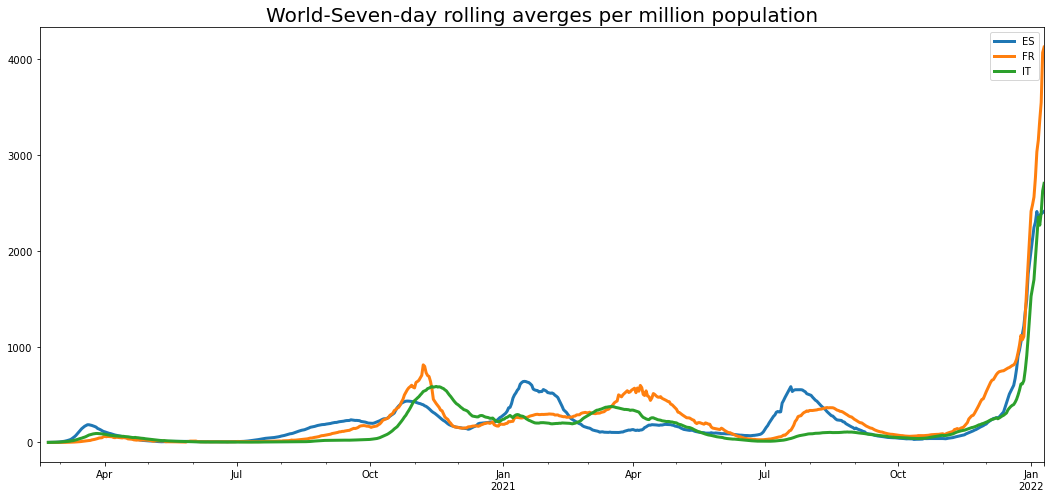

In [428]:
# Plot 7-day moving averge per million population
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = world_cases_by_million.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('World-Seven-day rolling averges per million population',fontsize=20);
#plt.savefig(f'./covid_data_update/us_rolling_avg_per_million_{day}.png');

In [ ]:
url = 'https://www.infoplease.com/us/states/state-population-by-rank'
tables = pd.read_html(url)
state_pop = tables[0].iloc[:-1,1:3]
state_pop.columns=('State','pop_millions')
state_pop.pop_millions = state_pop.pop_millions/1000000
state_pop.head()

In [ ]:
pwd

In [ ]:
df = pd.DataFrame(list(us_states.items()))
df.columns = ('State', 'Code')
df.head()

In [ ]:
state_population = pd.merge(df,state_pop,on='State')
state_population.head()

In [ ]:
state_population.to_csv('test.csv',index=False)

In [ ]:
df = pd.read_csv('test.csv')

In [ ]:
# translate States to Two-Letter codes
us_states = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}



In [ ]:
!pwd

In [ ]:
def polish_report_total(df):
    '''polish_report removes and reorders columns and assigns shortened names. It also
    creates a datetime index, changes strings to integers and handles NaNs
    Returns: a copy of the original df
    '''
    # eliminate unnecessary columns and re-order columns
    df = df.iloc[:,[-2,0,3,6,7]].copy()
    
    # shorten col names for easier manipulation
    df.columns = ['total','name','type', 'county','date']
    
    # use the date column as the index
    df.index = df.date
    df.drop('date',axis=1, inplace=True)
    
    # replace nuisance commas
    df.name = df.name.str.replace(',','_')
    
    return df

In [ ]:
# create dfs for both active and resolved sheets 
for i in range(2):
    i=i+1
    #df = pd.read_excel(f'covid_data/covid_report_{current_report}.xlsx',sheet_name=i,parse_dates=['Date reported to public health'])
    df = pd.read_excel('~/Desktop/covid-19-data/covid_data/covid_report_2021-12-22.xlsx',sheet_name=i,parse_dates=['Date reported to public health'])
    df = df.iloc[:,:16]
    df = polish_report_total(df)
    df = df.sort_index(ascending=False)
    if i == 1: 
        df1 = df.iloc[:,:4]
    elif i == 2: 
        df2 = df.iloc[:,:4]

In [ ]:
df1.head()

In [ ]:
df2.head()

In [ ]:
df1.shape

In [ ]:
df2.shape

In [ ]:
# Merge both dfs into a single and change all types to integers
totals = pd.merge(df1,df2,left_index=True, right_index=True,how='outer' ).fillna(0)
#totals = totals.astype(int)
totals.head()

In [ ]:
totals.shape

In [ ]:
#pd.merge?

In [ ]:
# Merge both dfs into a single and change all types to integers
totals = df1.merge(df2)
#totals = totals.astype(int)
totals.head()

In [ ]:
# Create a column which sums active and resolved totals
totals['all_reported_cases'] = totals.total_x+totals.total_y

# Create a Date column for plotting purposes 
# Keep only the last two columns
totals['Date'] = totals.index.strftime('%Y-%m')
totals = totals.iloc[:,-2:]
totals

In [ ]:
totals[['Date','all_reported_cases']].plot.bar(figsize=(10,6), \
                                x='Date',rot=45, width=.8, \
                                color="red",alpha=.7,\
                                title="Outbreaks (total new cases) in Colorado per month");

### More Detailed Inquiry

In [ ]:
# create dfs for both active and resolved sheets 
for i in range(2):
    i=i+1
    #df = pd.read_excel(f'covid_data/covid_report_{current_report}.xlsx',sheet_name=i,parse_dates=['Date reported to public health'])
    df = pd.read_excel('~/Desktop/covid-19-data/covid_data/covid_report_2021-12-22.xlsx',sheet_name=i,parse_dates=['Date reported to public health'])
    df = df.iloc[:,:16]
    df = polish_report_total(df)
    
    
    df = df.sort_index(ascending=False)
    if i == 1: 
        active = df
    elif i == 2: 
        resolved = df
        

In [ ]:
# Test code below
url ='https://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States'
tables = pd.read_html(url)
tables[1].tail()